In [ ]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import json
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
import pickle
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima as pm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
merged_n = pd.read_csv(r'/content/drive/MyDrive/Dissertation_10862121/merged_n.csv')

In [ ]:
merged_n['GMT'] = pd.to_datetime(merged_n['GMT'])
merged_n['Date'] = pd.to_datetime(merged_n['Date'])
merged_n.set_index('GMT', inplace=True)

In [ ]:
merged_n

,Total Household Consumption (N),Date,Time,Year,Month,Day,Hour,DayOfWeek,IsHoliday,Hourly Global Radiation (KJ/m2),Hourly Maximum Gust (kn),Hourly Mean Wind Direction (o),Hourly Mean Windspeed (kn),Hourly Pressure at Mean Sea Level (hPa),Hourly Rainfall Total (mm),Hourly Relative Humidity (%),Hourly Snow Depth (cm),Hourly Temperature (C),Hourly Total Cloud Cover (oktas)\n,Hourly Visibility (dm)
GMT,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,1657.483601,2013-01-01,00:00:00,2013,1,1,0,1,True,0.0,13.2,232.0,7.8,999.400,0.00,92.085714,0.0,8.914286,8.000000,2133.333333
2013-01-01 01:00:00,1422.045237,2013-01-01,01:00:00,2013,1,1,1,1,True,0.0,13.6,236.0,8.0,999.675,0.00,91.042857,0.0,8.785714,8.000000,1766.666667
2013-01-01 02:00:00,1200.551314,2013-01-01,02:00:00,2013,1,1,2,1,True,0.0,13.2,246.0,7.6,999.975,0.20,92.685714,0.0,8.514286,8.000000,1333.333333
2013-01-01 03:00:00,1061.568405,2013-01-01,03:00:00,2013,1,1,3,1,True,0.0,18.6,286.0,9.0,1000.725,0.96,89.871429,0.0,7.285714,7.666667,4100.000000
2013-01-01 04:00:00,1000.474013,2013-01-01,04:00:00,2013,1,1,4,1,True,0.0,15.4,278.0,7.4,1001.300,0.08,88.585714,0.0,6.700000,4.000000,5500.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,2979.858073,2013-12-31,19:00:00,2013,12,31,19,1,False,0.0,12.8,192.0,7.8,1002.900,0.00,85.385714,0.0,5.942857,6.333333,3666.666667
2013-12-31 20:00:00,2700.407931,2013-12-31,20:00:00,2013,12,31,20,1,False,0.0,13.6,196.0,7.4,1003.175,0.00,84.442857,0.0,5.442857,1.333333,4000.000000
2013-12-31 21:00:00,2447.194261,2013-12-31,21:00:00,2013,12,31,21,1,False,0.0,13.6,186.0,7.6,1003.450,0.00,83.257143,0.0,5.414286,1.000000,3833.333333


Daily Dataframe

In [ ]:
#New DataFrame storing daily aggregated data
daily_n = merged_n.resample('D').agg({
    'Total Household Consumption (N)': 'sum',
    'Hourly Temperature (C)': 'mean',
    'Hourly Pressure at Mean Sea Level (hPa)': 'mean',
    'Hourly Global Radiation (KJ/m2)': 'mean',
    'Hourly Rainfall Total (mm)': 'mean',
    'Hourly Mean Wind Direction (o)': 'mean',
    'Hourly Mean Windspeed (kn)': 'mean',
    'Hourly Maximum Gust (kn)': 'mean',
    'Hourly Visibility (dm)': 'mean',
    'Hourly Relative Humidity (%)': 'mean',
    'Hourly Total Cloud Cover (oktas)\n': 'mean',
}).reset_index()

In [ ]:
#Non-aggregated columns
daily_n['Date'] = daily_n['GMT'].dt.date
daily_n['Month'] = daily_n['GMT'].dt.month
daily_n['Day'] = daily_n['GMT'].dt.day
daily_n['DayOfWeek'] = daily_n['GMT'].dt.dayofweek

In [ ]:
#Renaming the columns for the weather variables to indicate they now contain daily averages
daily_n.rename(columns={
    'Hourly Temperature (C)': 'Daily Temperature (C)',
    'Hourly Pressure at Mean Sea Level (hPa)': 'Daily Pressure at Mean Sea Level (hPa)',
    'Hourly Global Radiation (KJ/m2)': 'Daily Global Radiation (KJ/m2)',
    'Hourly Rainfall Total (mm)': 'Daily Rainfall Total (mm)',
    'Hourly Mean Wind Direction (o)': 'Daily Mean Wind Direction (o)',
    'Hourly Mean Windspeed (kn)': 'Daily Mean Windspeed (kn)',
    'Hourly Maximum Gust (kn)': 'Daily Maximum Gust (kn)',
    'Hourly Visibility (dm)': 'Daily Visibility (dm)',
    'Hourly Relative Humidity (%)': 'Daily Relative Humidity (%)',
    'Hourly Total Cloud Cover (oktas)\n': 'Daily Total Cloud Cover (oktas)'
}, inplace=True)

In [ ]:
#Calculating 'Peak Day Value' and 'Peak Day Hour'
max_consumption_idx = merged_n.groupby(merged_n.index.date)['Total Household Consumption (N)'].idxmax()
peak_values = merged_n.loc[max_consumption_idx, 'Total Household Consumption (N)']
peak_hours = merged_n.loc[max_consumption_idx, 'Hour']

In [ ]:
#Creating dictionaries for mapping
peak_values_dict = dict(zip(peak_values.index.date, peak_values.values))
peak_hours_dict = dict(zip(peak_hours.index.date, peak_hours.values))

#Merging 'Peak Day Value' and 'Peak Day Hour' into the daily_aggregated DataFrame
daily_n['Peak Day Value'] = daily_n['Date'].map(peak_values_dict)
daily_n['Peak Day Hour'] = daily_n['Date'].map(peak_hours_dict)


In [ ]:
daily_n.drop(columns=['GMT'], inplace=True)

In [ ]:
daily_n['Date'] = pd.to_datetime(daily_n['Date'])
daily_n.set_index('Date', inplace=True)

In [ ]:
#Converting the 'IsHoliday' column in merged_n to integer type for summation
merged_n['IsHoliday'] = merged_n['IsHoliday'].astype(int)

#Grouping by 'Date' and sum the 'IsHoliday' column
daily_holidays = merged_n.groupby('Date').agg({'IsHoliday': 'sum'})

#Converting the summed values to a binary (0 or 1) indicating presence of holiday
daily_holidays['IsHoliday'] = daily_holidays['IsHoliday'].apply(lambda x: 1 if x > 0 else 0)

daily_n['IsHoliday'] = daily_n.index.map(daily_holidays['IsHoliday']).fillna(0).astype(int)

In [ ]:
daily_n

,Total Household Consumption (N),Daily Temperature (C),Daily Pressure at Mean Sea Level (hPa),Daily Global Radiation (KJ/m2),Daily Rainfall Total (mm),Daily Mean Wind Direction (o),Daily Mean Windspeed (kn),Daily Maximum Gust (kn),Daily Visibility (dm),Daily Relative Humidity (%),Daily Total Cloud Cover (oktas),Month,Day,DayOfWeek,Peak Day Value,Peak Day Hour,IsHoliday
Date,,,,,,,,,,,,,,,,,
2013-01-01,48554.429048,5.991667,1007.663542,169.819444,0.053056,261.166667,8.700000,15.141667,3816.666667,81.655952,3.097222,1,1,1,3232.153651,18,1
2013-01-02,49236.824514,6.440476,1023.133333,42.569444,0.022083,237.750000,7.083333,11.925000,2337.638889,91.691667,6.722222,1,2,2,3272.932430,19,0
2013-01-03,46679.941973,10.262500,1032.562500,73.277778,0.000000,257.666667,8.525000,14.816667,2503.611111,92.282738,7.611111,1,3,3,3160.668542,18,0
2013-01-04,46521.073230,9.350595,1037.157292,76.111111,0.001389,266.500000,8.466667,14.875000,2924.444444,85.682738,7.777778,1,4,4,3103.807307,18,0
2013-01-05,48215.904865,8.830952,1035.168750,52.430556,0.000000,244.916667,6.508333,11.458333,2072.361111,92.425000,7.041667,1,5,5,3199.016994,18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-27,47335.780581,8.875595,987.026042,51.805556,0.201111,213.416667,15.400000,28.516667,1995.972222,75.789286,5.013889,12,27,4,2936.761545,18,0
2013-12-28,46416.061681,5.114881,997.500000,139.125000,0.000000,229.916667,6.158333,10.891667,3338.888889,78.417262,2.847222,12,28,5,2933.939376,18,0
2013-12-29,48486.228501,3.575000,1014.921875,177.194444,0.009722,232.000000,6.266667,10.800000,2831.944444,84.811905,0.916667,12,29,6,3083.519833,18,0


Lags (Endogenous Variables)

In [ ]:
daily_n['lag_1_day_peak'] = daily_n['Peak Day Value'].shift(1)
daily_n['lag_2_day_peak'] = daily_n['Peak Day Value'].shift(2)
daily_n['lag_3_day_peak'] = daily_n['Peak Day Value'].shift(3)
daily_n['lag_4_day_peak'] = daily_n['Peak Day Value'].shift(4)
daily_n['lag_5_day_peak'] = daily_n['Peak Day Value'].shift(5)
daily_n['lag_6_day_peak'] = daily_n['Peak Day Value'].shift(6)
daily_n['lag_7_day_peak'] = daily_n['Peak Day Value'].shift(7)

In [ ]:
nan_rows = daily_n[daily_n.isna().any(axis=1)]
print(nan_rows)

            Total Household Consumption (N)  Daily Temperature (C)  \
Date                                                                 
2013-01-01                     48554.429048               5.991667   
2013-01-02                     49236.824514               6.440476   
2013-01-03                     46679.941973              10.262500   
2013-01-04                     46521.073230               9.350595   
2013-01-05                     48215.904865               8.830952   
2013-01-06                     50882.159539               7.158929   
2013-01-07                     47973.791500               7.730952   

            Daily Pressure at Mean Sea Level (hPa)  \
Date                                                 
2013-01-01                             1007.663542   
2013-01-02                             1023.133333   
2013-01-03                             1032.562500   
2013-01-04                             1037.157292   
2013-01-05                             1035.1

In [ ]:
daily_n.dropna(inplace=True)

Decomposition

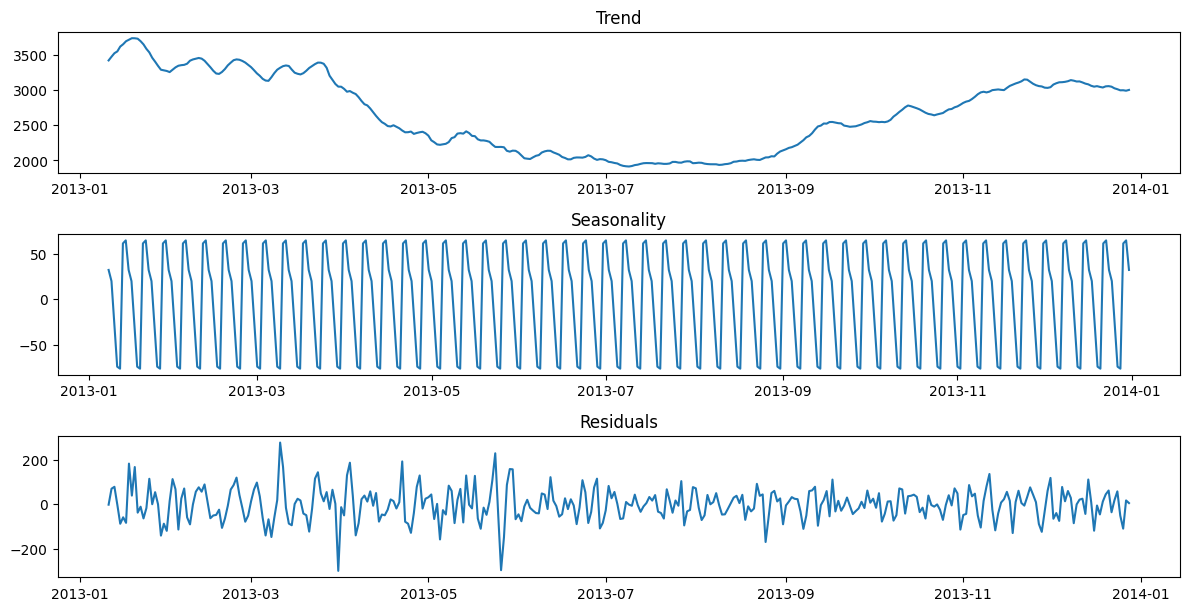

In [ ]:
decomposition = seasonal_decompose(daily_n['Peak Day Value'], model='additive')

plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(decomposition.trend)
plt.title('Trend')

plt.subplot(4, 1, 2)
plt.plot(decomposition.seasonal)
plt.title('Seasonality')

plt.subplot(4, 1, 3)
plt.plot(decomposition.resid)
plt.title('Residuals')

plt.tight_layout()
plt.show()

Differencing

ADF Statistic before differencing: -1.8891854824751213
p-value before differencing: 0.3371655785508538
ADF Statistic after differencing: -4.39766325167437
p-value after differencing: 0.0002996719183393718


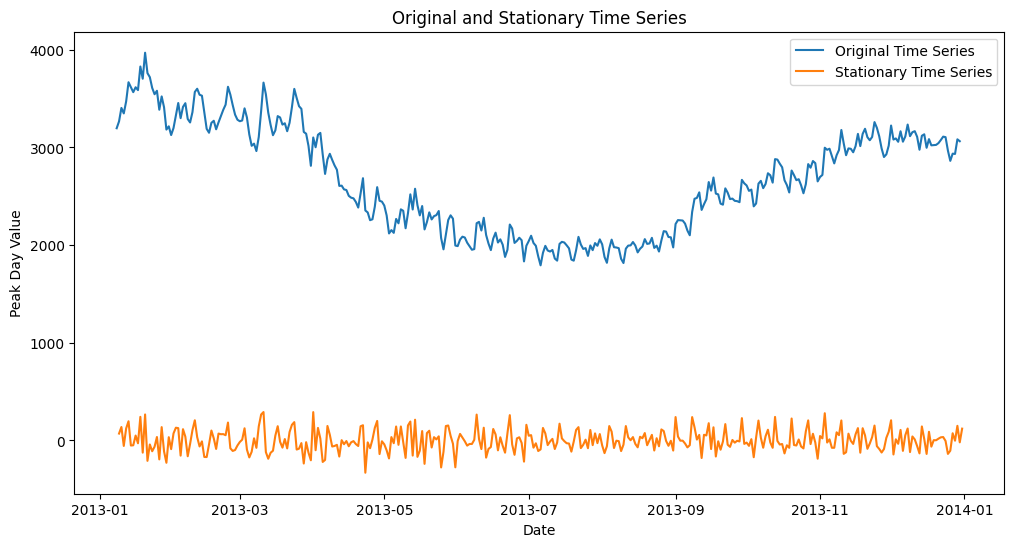

In [ ]:
#Augmented Dickey-Fuller test to check for stationarity before differencing
result_before_diff = adfuller(daily_n['Peak Day Value'].dropna())
print('ADF Statistic before differencing:', result_before_diff[0])
print('p-value before differencing:', result_before_diff[1])

#Differencing to make the time series stationary
stationary_peak_day_value = daily_n['Peak Day Value'].diff().dropna()

#Augmented Dickey-Fuller test again to check for stationarity after differencing
result_after_diff = adfuller(stationary_peak_day_value)
print('ADF Statistic after differencing:', result_after_diff[0])
print('p-value after differencing:', result_after_diff[1])

plt.figure(figsize=(12, 6))
plt.plot(daily_n.index[:-1], daily_n['Peak Day Value'].values[:-1], label='Original Time Series')
plt.plot(daily_n.index[1:], stationary_peak_day_value.values, label='Stationary Time Series')
plt.xlabel('Date')
plt.ylabel('Peak Day Value')
plt.title('Original and Stationary Time Series')
plt.legend()
plt.show()

ACF and PACF

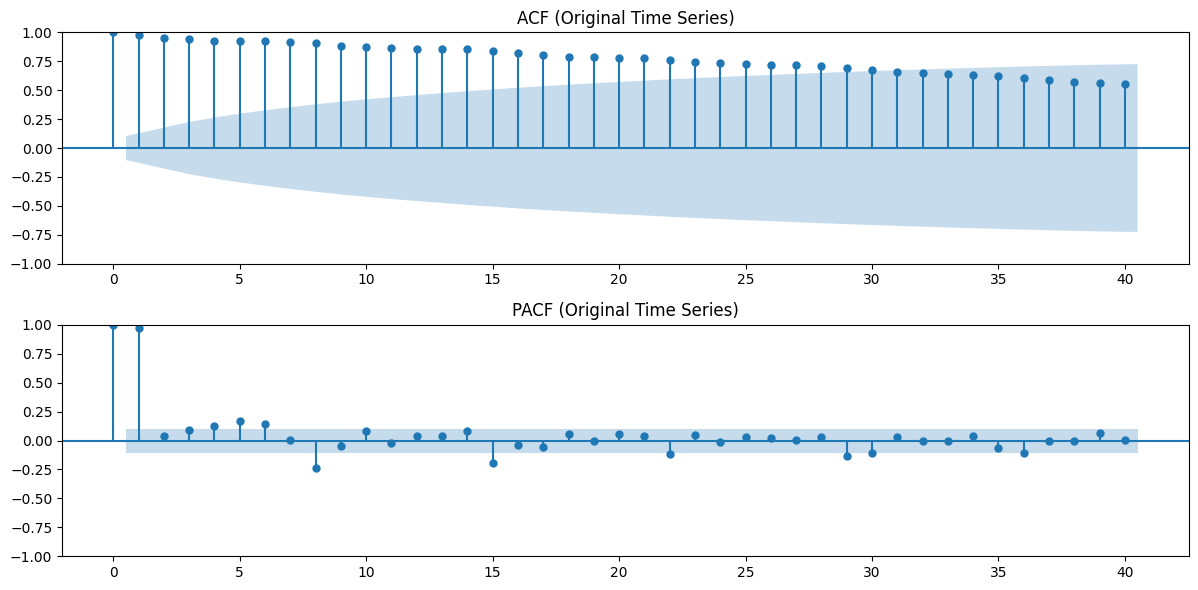

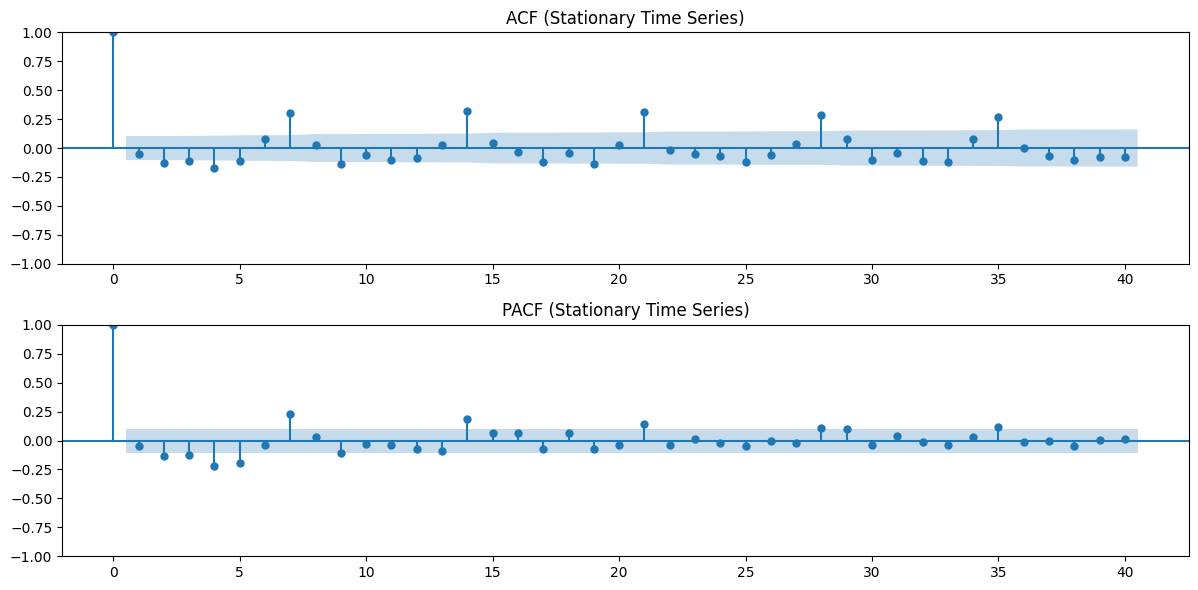

In [ ]:
#ACF and PACF before differencing
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(daily_n['Peak Day Value'].dropna(), lags=40, ax=plt.gca(), title='ACF (Original Time Series)')

plt.subplot(2, 1, 2)
plot_pacf(daily_n['Peak Day Value'].dropna(), lags=40, ax=plt.gca(), title='PACF (Original Time Series)')

plt.tight_layout()
plt.show()

#ACF and PACF after differencing
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(stationary_peak_day_value, lags=40, ax=plt.gca(), title='ACF (Stationary Time Series)')

plt.subplot(2, 1, 2)
plot_pacf(stationary_peak_day_value, lags=40, ax=plt.gca(), title='PACF (Stationary Time Series)')

plt.tight_layout()
plt.show()

SARIMAX

Feature Selection

In [ ]:
daily_n = daily_n.drop(columns=["Daily Mean Windspeed (kn)"])

In [ ]:
end_of_october = daily_n.index.get_loc('2013-10-31')

Train/Test Split

In [ ]:
train_data = daily_n.iloc[:end_of_october+1]
test_data = daily_n.iloc[end_of_october+1:]

In [ ]:
#Exogenous variables
exog_train = train_data.drop(columns=['Peak Day Value', 'Peak Day Hour',])
exog_test = test_data.drop(columns=['Peak Day Value', 'Peak Day Hour'])

Best Parameters

In [ ]:
#Using auto_arima to find best SARIMAX parameters
best_params = auto_arima(train_data['Peak Day Value'], exogenous=exog_train, seasonal=True, m=7,
                          trace=True, suppress_warnings=True, stepwise=True, max_order=None)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.58 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3647.116, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=3625.991, Time=0.38 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=3634.025, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3645.193, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=3648.778, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=3608.889, Time=0.83 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=3576.790, Time=1.53 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=3574.898, Time=0.89 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=3634.343, Time=0.25 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=3576.801, Time=1.92 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=3622.095, Time=0.49 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=3576.2

In [ ]:
print(best_params.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  297
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -1778.543
Date:                           Fri, 25 Aug 2023   AIC                           3569.086
Time:                                   17:02:14   BIC                           3591.228
Sample:                               01-08-2013   HQIC                          3577.951
                                    - 10-31-2013                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7075      0.095      7.411      0.000       0.520       0.895
ar.L2          0.0052      0.060      0.085

Fit & Predict

In [ ]:
model = SARIMAX(train_data['Peak Day Value'], exog=exog_train, order=best_params.order, seasonal_order=best_params.seasonal_order)
results = model.fit(disp=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
forecast_obj = results.get_forecast(steps=61, exog=exog_test[:61])
forecast = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int()

Performance Metrics

In [ ]:
mae = mean_absolute_error(test_data['Peak Day Value'], forecast)
mape = np.mean(np.abs((test_data['Peak Day Value'] - forecast) / test_data['Peak Day Value'])) * 100

In [ ]:
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

MAE: 60.42241545276636
MAPE: 1.9731695676856713


Plot

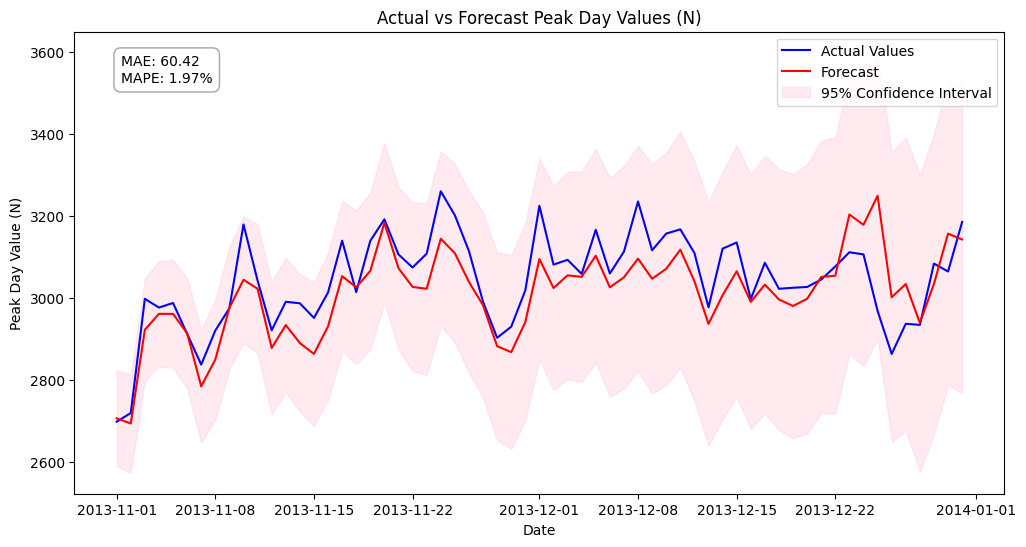

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Peak Day Value'], label="Actual Values", color='blue')
plt.plot(test_data.index, forecast, label="Forecast", color='red')
plt.fill_between(test_data.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label="95% Confidence Interval")
plt.legend(loc='best')
plt.title("Actual vs Forecast Peak Day Values (N)")

plt.xlabel("Date")
plt.ylabel("Peak Day Value (N)")

textstr = f'MAE: {mae:.2f}\nMAPE: {mape:.2f}%'
props = dict(boxstyle='round, pad=0.5', facecolor='white', edgecolor='gray', alpha=0.7)

plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, verticalalignment='top', bbox=props)

plt.show()

In [ ]:
results_df = pd.DataFrame({
    'Date': test_data.index[:61],
    'Actual': test_data['Peak Day Value'].values[:61],
    'Predicted': forecast[:61]
})

results_df['Actual'] = results_df['Actual'].apply(lambda x: '{:.2f}'.format(x))
results_df['Predicted'] = results_df['Predicted'].apply(lambda x: '{:.2f}'.format(x))

results_df['Difference (%)'] = ((results_df['Predicted'].astype(float) - results_df['Actual'].astype(float)) / results_df['Actual'].astype(float)) * 100

results_df['Difference (%)'] = results_df['Difference (%)'].apply(lambda x: '{:.2f}%'.format(x))

print(results_df)

                 Date   Actual Predicted Difference (%)
2013-11-01 2013-11-01  2697.88   2706.13          0.31%
2013-11-02 2013-11-02  2718.94   2693.46         -0.94%
2013-11-03 2013-11-03  2997.60   2922.14         -2.52%
2013-11-04 2013-11-04  2976.29   2960.99         -0.51%
2013-11-05 2013-11-05  2987.40   2960.86         -0.89%
...               ...      ...       ...            ...
2013-12-27 2013-12-27  2936.76   3033.65          3.30%
2013-12-28 2013-12-28  2933.94   2938.70          0.16%
2013-12-29 2013-12-29  3083.52   3034.07         -1.60%
2013-12-30 2013-12-30  3064.23   3156.60          3.01%
2013-12-31 2013-12-31  3185.08   3142.49         -1.34%

[61 rows x 4 columns]


Model Diagnostics

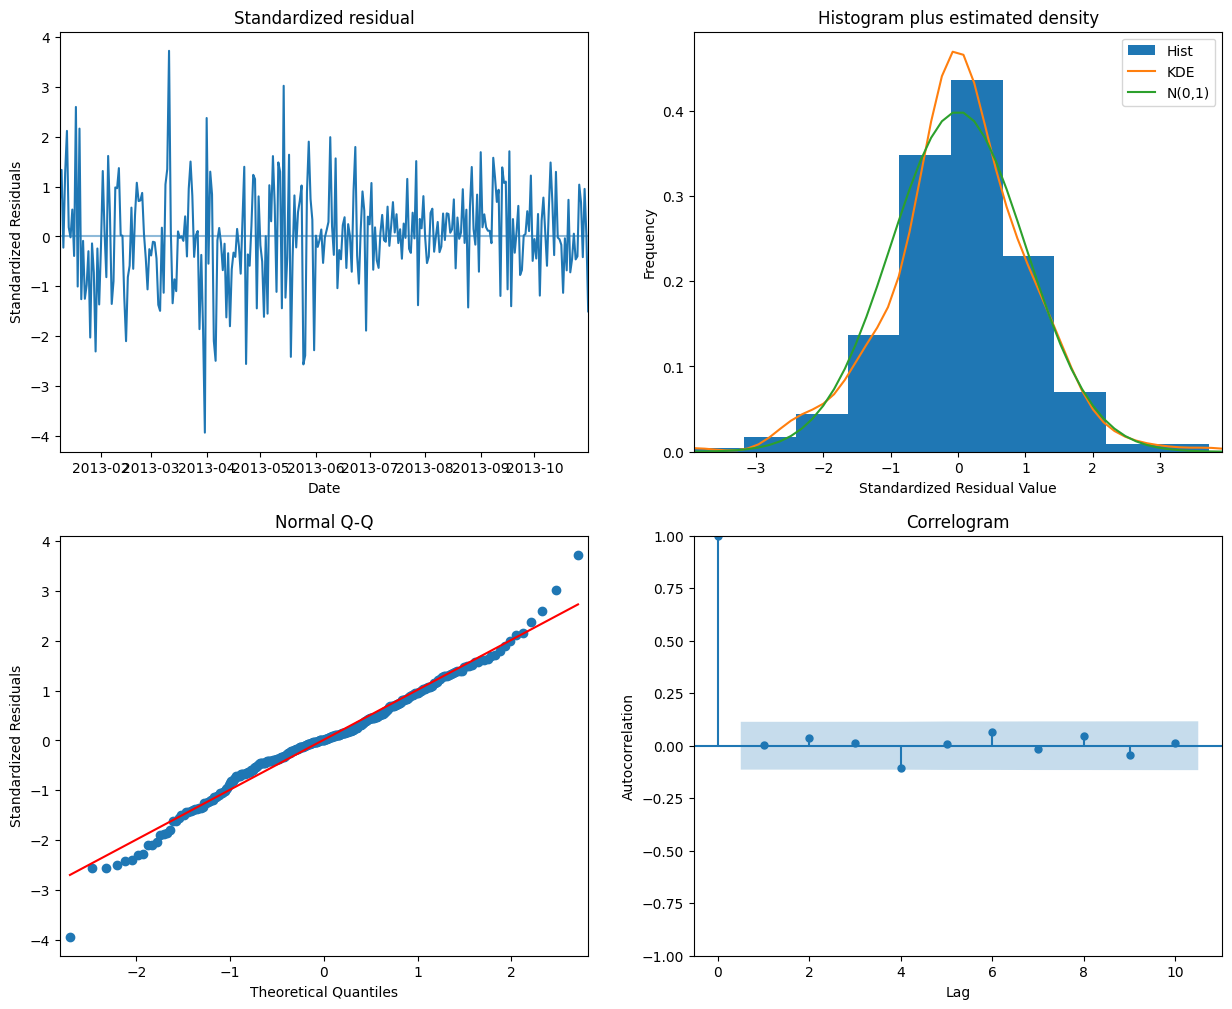

In [ ]:
fig = best_params.plot_diagnostics(figsize=(15,12))

ax = fig.axes[0]
ax.set_xlabel('Date')
ax.set_ylabel('Standardized Residuals')

ax = fig.axes[1]
ax.set_xlabel('Standardized Residual Value')
ax.set_ylabel('Frequency')

ax = fig.axes[2]
ax.set_xlabel('Theoretical Quantiles')
ax.set_ylabel('Standardized Residuals')

ax = fig.axes[3]
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')

plt.show()
